# Chapter 1 - Basics of Diffusion

## What is Diffusion?

A diffusion model is a probabilistic generative model that generates data by using a series of noising and denoising process. 

There are 2 steps here:
<ul>
<li>Forward process: Add noise to data over a series of timesteps. Basically, take an image, keep adding noise progressively over it to convert the image to pure noise.</li>
<li>Reverse process: Take pure noise, remove noise progressively from the noise to create/generate the original data from noise.</li>
</ul>

The forward process is fairly easy. You just take an image, add gaussian noise to it. The reverse process is hard and that is what we want our model to learn

### Forward Process (Noising)

The forward process is all about taking data (images in our case), and adding noise to it. 

We have our image $x$. We add noise to it over $T$ timesteps, meaning we keep adding noise to the image slowly for $T$ timesteps, allowing our image to slowly, gradually turn into pure noise.

We'll start with a single step. A single step here is taking an image, and adding some noise to it. <br>

Let's look at an example of adding noise to an image from the MNIST dataset using Pytorch.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

Let's load the MNIST dataset from Pytorch's datasets class.

In [2]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
mnist_data = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transform)

We'll now pull out a random image from the Pytorch dataset.

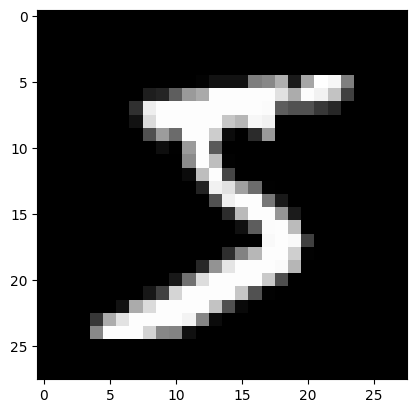

In [3]:
image = mnist_data[0][0]  # Take the first image (shape: [1, 28, 28])
plt.imshow(image.squeeze(0), cmap='gray') #tensor.squeeze converts the image from a shape of [1, 28, 28] to [28, 28]

Now finally, let's generate some noise and add it to the image.

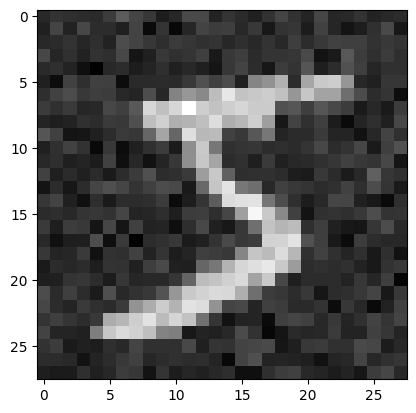

In [4]:
noise = torch.randn_like(image) * 0.1
noisy_image = image + noise
plt.imshow(noisy_image.squeeze(0), cmap = 'gray')

Let's formalize this. 

We have $x_0$ which is our initial original image. $x_1$ is the image we get by adding noise to $x_0$. $x_2$ is the image we get by adding noise to $x_1$, and so on. We can represent the image we get after adding noise $t$ times to $x_0$ progressively as $x_t$. 

So, effectively, $x_t$ is just $x_{t-1}$ plus some noise. Let's put it a bit formally: 
$$x_t = x_{t-1} + \epsilon$$ 
$$\epsilon \sim \mathcal{N}(0, I)$$

In plain English, the first equation tells us that $x_t$ is just some noise added to $x_{t-1}$. The second equation is just indicating that $\epsilon$ is just a noise that we sample from a normal distribution. The 0 represents the mean, and the $I$ is the covariance matrix with 1s on the diagonal indicating that the noise added to each pixel is independent of each other.  

So, now, let's see in code, how we can add noise to an image progressively over multiple steps. We'll also look at how these images look like after different timesteps. 

In [5]:
def add_noise_simple(image, T):
    """
    Repeatedly add Gaussian noise to an image over T timesteps.
    """
    noisy_images = []
    current_image = image.clone()  # Clone to avoid modifying the original image
    for t in range(T):
        noise = torch.randn_like(image) * 0.1  # Generate Gaussian noise
        current_image += noise  # Add noise to the image
        noisy_images.append(torch.clamp(current_image, 0, 1))  # Keep pixel values in [0, 1]
    return noisy_images

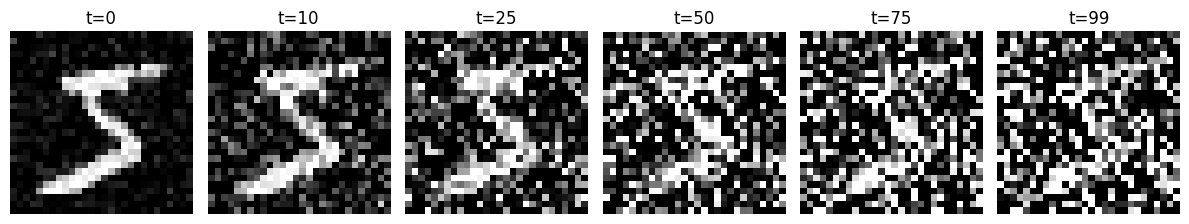

In [6]:
T = 100  # Number of timesteps
noisy_images = add_noise_simple(image, T)
# Visualize original and noisy images at different timesteps
timesteps_to_show = [0, 10, 25, 50, 75, T-1]
plt.figure(figsize=(12, 6))
for i, t in enumerate(timesteps_to_show):
    plt.subplot(1, len(timesteps_to_show), i + 1)
    plt.imshow(noisy_images[t].squeeze().numpy(), cmap='gray')
    plt.title(f"t={t}")
    plt.axis('off')
plt.tight_layout()
plt.show()

So, that was pretty straight forward. We take an image, generate some gaussian noise, add it to an image, generate a new noisy image which still represents the original image, but a bit more noisy. Then, we take the noisy image, add noise to it again make it more noisy. 

We iteratively do this for $T$ timesteps, eventually getting to a point where at timestep $T$ (in the above example it is 100), the resultant image is just pure noise, one that looks completely irrelevant to the original image. 

There are a few issues with the above logic. <br>

One, we can see that by the time we get to the 75th image, we almost completely lose the structure. We don't want that to happen. We want to gradually remove the noise because we also want it easier for the model to understand how much noise has been added. So, we would like to add very very little noise for a large number of timesteps, like 1000.

The other issue is that everytime we want to calculate the noise added at Timestep $t$, we have to iterate $t$ times. It would be more convenient to just have a simple formula to calculate it in a single step i.e, go from $x_0$, to $x_t$ in one step directly. We'll first start with solving this problem first, before we get into solving the problem of gradually adding noise. 

To get to this, we need to make slight modifications into how we approach this. 

Let's get a bit formal to understand this. 

Now, we'll start formalizing the process of how we go from $x_{t-1}$ to $x_t$. Look at the following equation: $$x_t = \sqrt{{\alpha}_t} \, x_{t-1} + \sqrt{1 - {\alpha}_t} \, \epsilon$$
where, <br>
<ul>
    <li>${\alpha}_t$ controls how much portion of the previous image $x_{t-1}$ we retain </li>
    <li>$(1 - {\alpha}_t)$ tells how much of the sampled noise is taken. So, effectively, we are controlling how much of the original image we are retaining and how much of the noise we are taking into account when generated $x_t$. </li>
</ul>


So, let's break it down into plain English. Also let's ignore the square roots for now (I'll explain why we add that later). Let's look at the formula without square roots: $$x_t = {\alpha}_t \, x_{t-1} + 1 - {\alpha}_t \, \epsilon$$ <br>
<br>
${\alpha}_t$ is a number between 0 and 1. At $t=0$, ${\alpha}_0 = 1$.

So let's say in the first timestep, we want to retain 99% of the original image ($x_0$) and only want 1% of it to have noise, then we'll set ${\alpha}_1 = 0.99$

Let's look at this works with the above formula. <br>

So at t=1, we will set ${\alpha}_1 = 0.99$. In that case $1 - {\alpha}_1$ will be 0.01. Substituting those two terms in the above equation for $x_t$, in our case then, 

$$x_1 = {\alpha}_1 \, x_{0} + ({1 - {\alpha}_1}) \, \epsilon$$ <br> $$x_1 = 0.99 * x_{0} + (1-0.99) * \epsilon$$ <br> $$x_1 = x_{t-1} + 0.01 * \epsilon$$

The above equation points that we will retain 99% of the original image, and add 1% of the generated noise to the original image, to create a slightly noisy image. 


Let's look at this as code.

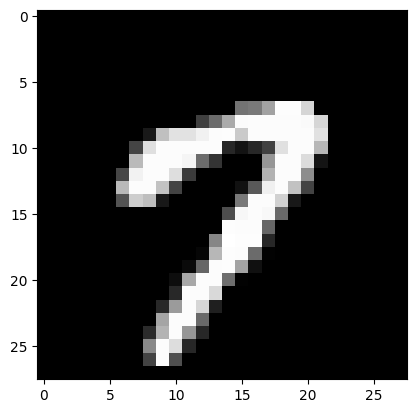

In [7]:
image = mnist_data[15][0]  # Take the first image (shape: [1, 28, 28])
plt.imshow(image.squeeze(0), cmap='gray') #tensor.squeeze converts the image from a shape of [1, 28, 28] to [28, 28]

We'll define a function that takes in the image and a value for alpha and calculates a resulting image accordingly. 

In [8]:
def add_noise_with_alpha(image, alpha):
    noise = torch.randn_like(image)
    noisy_image = (alpha * image) + ((1-alpha) * noise)
    return noisy_image

In this case, let's have ${\alpha}_t$ as 0.9, meaning we want to retain 90% of the original image, and the rest will be noise. 

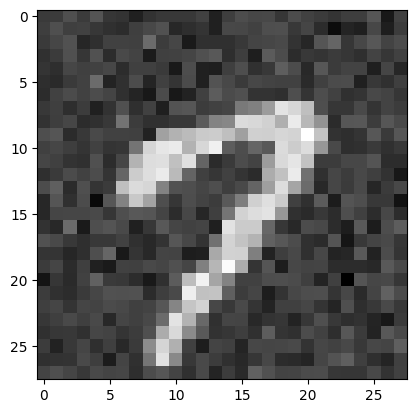

In [9]:
noisy_image = add_noise_with_alpha(image, alpha=0.9)
plt.imshow(noisy_image.squeeze(0), cmap='gray')

As mentioned before, when $t=1$, ${\alpha}_t$ will be close to 1, so when you multiply ${\alpha}_0$ with $x_0$, then the resultant $x_1$ remains the same, or nearly the same as $x_0$. <br>
Also, when $t=1$, $(1 - \bar{\alpha}_t)$ will be a very very low value, meaning when it is multiplied with the noise $\epsilon$, the value of it will be very very low that no noise or very little noise will be added. As a consequence, most of the image will be retained. 

So, do this iteratively, we can set a constant ${\alpha}_t$. Maybe we can set it at 0.99. So, at each step, we set the ${\alpha}_t$ at 0.99. 

For let's do this for three steps. 

$$x_1 = (0.99 * x_0) + (0.01 * \epsilon)$$ 

Then, x_2 will be dependent on $x_1$ and the same $\alpha$. Same goes for $x_3$.

$$x_2 = (0.99 * x_1) + (0.01 * \epsilon)$$
$$x_3 = (0.99 * x_2) + (0.01 * \epsilon)$$
$$x_4 = (0.99 * x_3) + (0.01 * \epsilon)$$

Let look at this as code.

In [10]:
x_0 = mnist_data[15][0]
noisy_images = [x_0]
current_image = x_0
for i in range(1, 5):
    print(f'Generating x_{i}')
    current_image = add_noise_with_alpha(current_image, alpha=0.99)
    noisy_images.append(current_image)


Generating x_1
Generating x_2
Generating x_3
Generating x_4


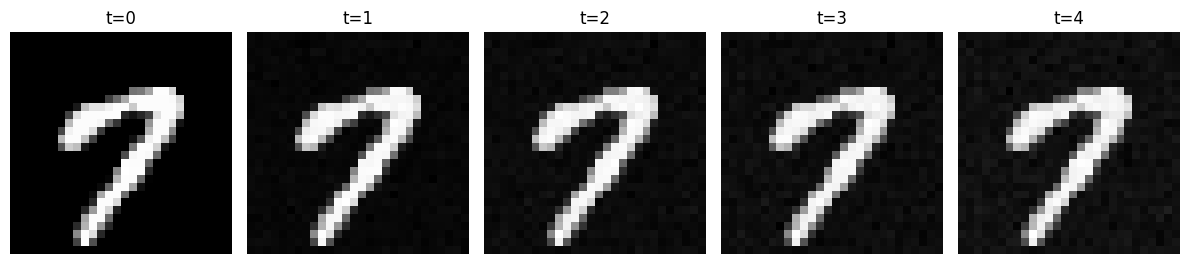

In [11]:
plt.figure(figsize=(12, 5))
timesteps_to_show = [0, 1, 2, 3, 4]
for i, t in enumerate(timesteps_to_show):
    plt.subplot(1, len(timesteps_to_show), i + 1)
    plt.imshow(noisy_images[t].squeeze().numpy(), cmap='gray')
    plt.title(f"t={t}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Now, let's go and see how to go from $x_0$ to $x_t$, let's assume $x_2$. 

Let's take our previous example and go step by step from $x_0$ to $x_2$.
$$\alpha = 0.99$$
$$x_1 = (0.99 * x_0) + (0.01 * \epsilon)$$ 
$$x_2 = (0.99 * x_1) + (0.01 * \epsilon)$$

Let's substitute the equation of $x_1$ in $x_2$. 

$$x_2 = (0.99 * (0.99 * x_0)) + (0.99 * (0.99 * \epsilon)$$ 
$$x_2 = (0.99^2 * x_0) + (0.99^2 * \epsilon)$$
$$x_2 = ({\alpha}^2 * x_0) + ({\alpha}^2 * \epsilon)$$

This gives us one thing. If we want to calculate $x_2$, we multiply $\alpha$ twice with itself. For $x_3$ it'll be ${\alpha}^3$ and so on. 

So, let's introduce $\bar{\alpha}_t$.

$$\bar{\alpha}_t = \prod_{i=1}^{t} \alpha_i$$

So, for $t=2$,
$$\bar{\alpha}_2 = \prod_{i=1}^{2} \alpha_i$$
$$\bar{\alpha}_t = \alpha_1 * \alpha_2$$
And since in our case, we can constant alpha, 
$$\bar{\alpha}_t = \alpha^2$$

Let's define a equation that uses this to go from $x_0$ to $x_t$,
$$x_t = {\bar{\alpha}_t} \, x_0 + {1 - \bar{\alpha}_t} \, \epsilon$$

So, if $t=2$, then, 
$$x_2 = {\bar{\alpha}_2} \, x_0 + {1 - \bar{\alpha}_2} \, \epsilon$$
$$x_2 = {\alpha^2} \, x_0 + {1 - {\alpha}^2} \, \epsilon$$


There you go. So, we now have a simple formula that allows us to directly go from $x_0$ to $x_t$. Let's code this now. 

In [12]:
constant_alpha = 0.99
alphas = [1]
for i in range(1,100):
    alphas.append(alphas[i-1] * constant_alpha)

In [13]:
x_0 = mnist_data[15][0]

noisy_images = [x_0]

for i in range(1, 100):
    current_image = (x_0 * alphas[i]) + (1 - alphas[i]) * torch.randn_like(x_0)
    noisy_images.append(current_image)

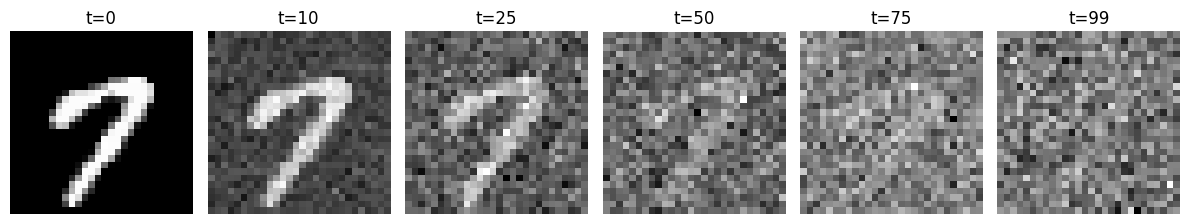

In [14]:
timesteps_to_show = [0, 10, 25, 50, 75, 99]
plt.figure(figsize=(12, 6))
for i, t in enumerate(timesteps_to_show):
    plt.subplot(1, len(timesteps_to_show), i + 1)
    plt.imshow(noisy_images[t].squeeze().numpy(), cmap='gray')
    plt.title(f"t={t}")
    plt.axis('off')
plt.tight_layout()
plt.show()

So, we've implemented the above formula, where while calculating the noisy image for each timestep, we calculate it directly from $x_0$.

But, we see a problem here. We see that in t=50, we lose majority of the structure and we don't want that to happen. We want it to be very very gradual so that we can make it easier for the model to learn the amount of noise that has been added. 

So, let's make a slight difference. 

Lets print the first and last value of the alphas that we used. 

In [15]:
print(f'At t=0: {alphas[0]}')
print(f'At t=10: {alphas[10]}')
print(f'At t=25: {alphas[25]}')
print(f'At t=50: {alphas[50]}')
print(f'At t=99: {alphas[-1]}')

At t=0: 1
At t=10: 0.9043820750088043
At t=25: 0.7778213593991465
At t=50: 0.6050060671375365
At t=99: 0.36972963764972655


So, even at the last timestep, we get to 0.369 of the original image, but still visually we find the last image to be very very noise. Or even at t=50, we retain more than half the original image with alpha at 0.6, but still visually we barely recognize the original image's information. But we don't want that to happen. We want to "destroy" x_0 gradually, not immediately. So, we'll make a few changes. 

So, we set our constant alpha at $\alpha=0.99$, meaning 0.9900. It may seem like a small number, but turns big when we use it multiple times. 

But instead we'll set it at $\alpha=0.9999$. We'll generate a set of values between 0.9999 and 0.9800. And based on this, we'll generate a bunch of alphas. We call this linear scheduling. 

Let's put it this way. We'll generate a bunch of alphas. $$\alpha = [0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998, 0.9997]$$

So, to calculate $\alpha_t$, we'll do, $$\alpha_t = \alpha_0 * \alpha_1 * ... \alpha_{t-1}$$

For eg, in our case, with the above alphas, $$\alpha_2 = \alpha_0 * \alpha_1 * $$ $$\alpha_2 = 0.9999 * 0.9999$$

Let's have a look at how to do it with code. 

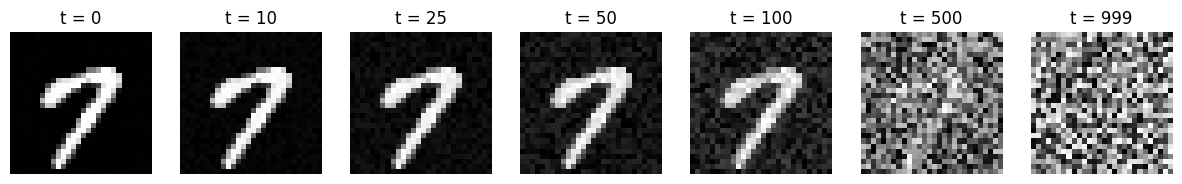

In [16]:
T = 1000 #Number of timesteps
beta = torch.linspace(0.0001, 0.02, T)
alphas = 1- beta
alpha_bars = torch.cumprod(alphas, dim=0)

def add_noise(x_0, t, alphas, alpha_bars):
    noise = torch.rand_like(x_0)

    alpha_bar_t = alpha_bars[t].view(-1, 1, 1, 1)
    
    x_t = torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    return x_t, noise

timesteps = [0, 10, 25, 50, 100, 500, 999] 

fig, axs = plt.subplots(1, len(timesteps), figsize=(15, 5))
sample_image = x_0.unsqueeze(0)
for i, t in enumerate(timesteps):
    noisy_image, noise = add_noise(sample_image, t, alphas, alpha_bars)
    axs[i].imshow(noisy_image.cpu().squeeze(), cmap="gray")
    axs[i].set_title(f"t = {t}")
    axs[i].axis("off")



In [17]:
print(f'At t=0: {alpha_bars[0].item()}')
print(f'At t=10: {alpha_bars[10].item()}')
print(f'At t=25: {alpha_bars[25].item()}')
print(f'At t=50: {alpha_bars[50].item()}')
print(f'At t=99: {alpha_bars[99].item()}')

At t=0: 0.9998999834060669
At t=10: 0.9978064894676208
At t=25: 0.9909650683403015
At t=50: 0.969951331615448
At t=99: 0.8970179557800293


Let's also do a comparison with constant alphas and linear scheduler. 

$$
\begin{array}{|c|c|c|}
\hline
\text{t} & \text{Constant } \alpha = 0.99 & \text{Linear Scheduler} \\ 
\hline
0 & 1 & 0.9998 \\ 
10 & 0.9043820750088043 & 0.9978 \\ 
25 & 0.7778213593991465 & 0.9909 \\ 
50 & 0.6050060671375365 & 0.9699 \\ 
99 & 0.36972963764972655 & 0.8970 \\ 
\hline
\end{array}
$$



We can see that with the linear scheduler there is a much more gradual decrease, which is what we want. And if you look at the plot above, you can see that with the linear schedule the noise being added is also more subtle.

We are doing this because, if we have a more drastic decrease like in the case of constant alpha, the model won't be able to predict how much noise was added. 

Let's also plot the alphas of linear scheduler to just understand it a bit better. 

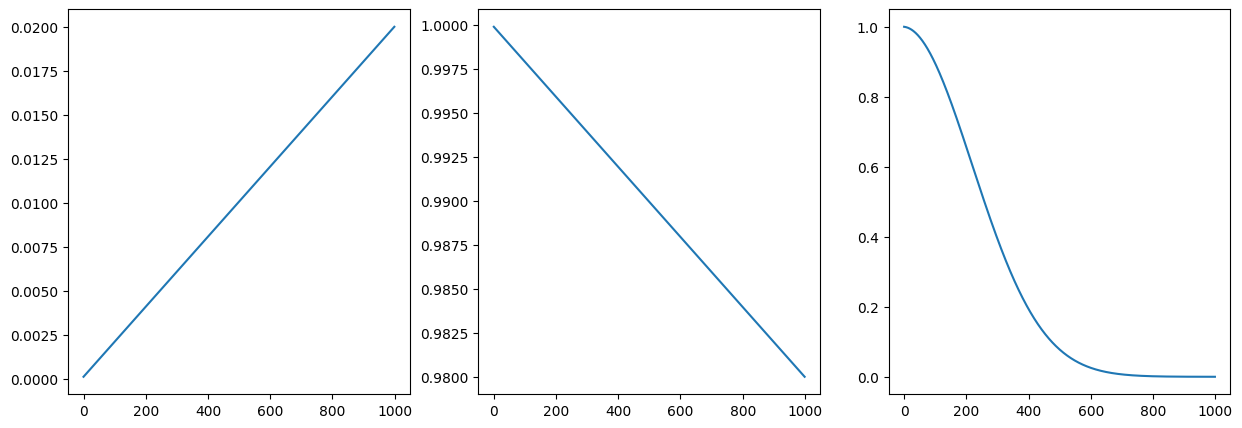

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(beta)
axs[1].plot(alphas)
axs[2].plot(alpha_bars)

Greattt! Now that we understand the alphas and schedulers, let us cross a t that we have missed. Until now, we considered our equation to be $$x_t = {\alpha}_t \, x_{t-1} + 1 - {\alpha}_t \, \epsilon$$

But, if you noticed at the start, the actual equation was, $$x_t = \sqrt{{\alpha}_t} \, x_{t-1} + \sqrt{1 - {\alpha}_t} \, \epsilon$$

So, why do we need the square roots. Even without them, it made a lot of sense right. Well it does, and its perfectly alright. The square roots are added for convenience purposes. Adding the square root helps preserve the "variance of the image". But, what is the variance of an image? 

Let us get back to the basics. 

An image is just a matrix of pixel values, meaning, just a matrix of numbers. If we consider each pixel as a random variable, then the variance tells us how much the pixels fluctuate across the distribution. 

For eg, 
<ul>
    <li>A plain black image (all pixels are 0 in a 0-255 scale) has a Variance of 0 as the pixels don't change at all. </li>
    <li>A noisy image (some pixels are 50, some are 200 and so on) will have a higher variance because the pixel values in the image matrix keep changing. </li>
</ul>
<img alt = "Image depicting the variance of various kinds of images" src="images/Chapter 1/image-variance" width="400"/>

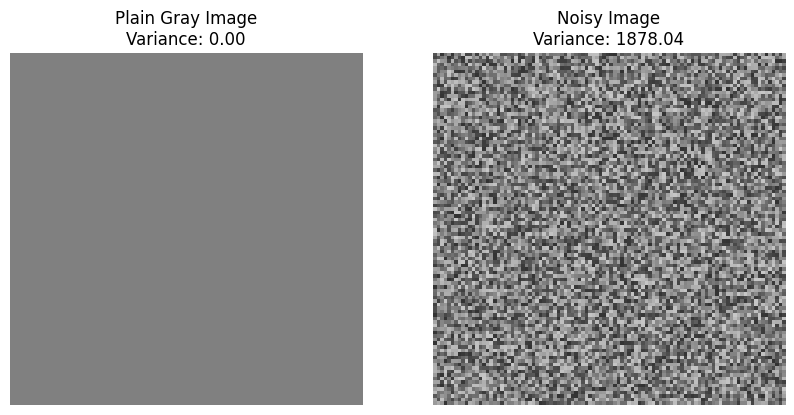

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Create a plain gray image (all pixels = 128)
gray_image = np.full((100, 100), 128, dtype=np.uint8)

# Create a noisy image (random pixel values between 50 and 200)
noisy_image = np.random.randint(50, 200, (100, 100), dtype=np.uint8)

# Compute variance for both images
gray_variance = np.var(gray_image)
noisy_variance = np.var(noisy_image)

# Plot the images with variance values
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(gray_image, cmap='gray', vmin=0, vmax=255)
axes[0].set_title(f"Plain Gray Image\nVariance: {gray_variance:.2f}")
axes[0].axis('off')

axes[1].imshow(noisy_image, cmap='gray', vmin=0, vmax=255)
axes[1].set_title(f"Noisy Image\nVariance: {noisy_variance:.2f}")
axes[1].axis('off')

plt.show()


Perfect. So, how does this relate to our equation. Why does the variance matter when we add noise to an image?

Well, when we add noise to $x_0$ iteratively in the forward process, we are effectively transforming it step by step to pure Gaussian noise. At $t=0$, the variance of image is low. As we keep adding noise, the variance of the image will start increasing as we are adding noise, which is random pixel values to the image. 

When developing diffusion models, we want the variance of image from one step to step to change gradually, not drastically. If it is drastic, it will be harder for the model to learn how to identify the noise. So, to ensure that this is stable, instead of directly using $\bar{\alpha}$, we instead go for $\sqrt{\bar\alpha}$.

At $t=T$, for the noisy image, the resulting image's variance should be high, meaning, the variance of a image that is pure gaussian noise. 



Let's look at this a bit more mathemtically.

Let's say we have a random variable $X$, which has a mean of $\mu$ and variance of ${\sigma}^2$. If we scale the random variable by a constant $c$, the variance changes as follows: $$Var(cX) = {c^2}.Var(X)$$

You can see in the above equation that if you take $X$ a scale it by $c$, then the variance increases by $c^2$. 

This means, if we scale $X$ by $2$, the variance of X goes by $2^2=4$. This means, if we scale $X$ by $0.5$, the variance of X goes by $0.5^2=0.25$.

How does this relate to our diffusion process. Well, like we discussion before, the goal is to ensure we reduce the contribution of $x_0$ over time, by gradually adding noise over $T$ timesteps. So, we have two ways here. 

Case 1: Without the square root: $x_t = {\alpha}_t \, x_{t-1} + 1 - {\alpha}_t \, \epsilon$ <br>
Case 2: With the square root $x_t = \sqrt{{\alpha}_t} \, x_{t-1} + \sqrt{1 - {\alpha}_t} \, \epsilon$

The ${\alpha}_t$ part is resposible for scaling the input image $x_t$. So each time you scale it by ${\alpha}_t$ as we have in case 1, since the variance will increase by $c^2$, the variance of $x_t$ in our case will scale by ${{\alpha}_t}^2$. If the variance increases in a squared rate, then the original image will fade away too quickly. The variance between $x_{t-1}$ and $x_t$ will be so huge that the model will find it very very hard to actually learn the noise that was generated. 

Now, let's goto case 2, where we have $\sqrt{{\alpha}_t}$. In this case, since we are scaling $x_t$ by $\sqrt{{\alpha}_t}$ instead of ${\alpha}_t$, the variance will only scale by ${\sqrt{{\alpha}_t}}^2$, which is just ${\alpha}_t$; and that will change the variance in a much more gradual way allowing the model to learn the noise added between various timesteps, easily. 

#### Why do we call this a probabilistic model? (Optional)

Note: This is completely optional, but if you want to do further research into this space, then it can help to understand this.

However, feel free to jump to Backward Diffusion and come back to this anytime. Backward Diffusion is about removing noise and generating Images!

Let's understand this a bit formally


Mathematically, $$q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \alpha_t x_{t-1}, (1-\alpha_t)\mathbf{I})$$
where, 
<ul>
<li>$x_t$ is the image after adding noise at timestep t</li>
<li>$\alpha_t$ controls how much noise is added to the image at each timestep</li>
<li>$\mathcal{N}$ represents the gaussian distribution</li>
<li>$I$ is means the noise added to each pixel is independent of each other</li>
    
</ul>

In plain English, $q(x_t \mid x_{t-1})$ represents the conditional probability of getting $x_t$ given the image from the previous step, $x_t-1$. In other words how likely is it to get noisy image $x_t$ from the previous image $x_t-1$.

But, why do we even need this equation. Can't we simply say $$x_t = x_{t-1}+ {N}$$

where, 
<ul>
    <li>$x_t$ is the image after adding noise at timestep t.</li>
    <li>${N}$ is the gaussian noise.</li>
</ul>

This is much more simpler, isn't it? Well it is, and practically that is what we do. But, what $q(x_t \mid x_{t-1}) = \mathcal{N}(x_t; \alpha_t x_{t-1}, (1-\alpha_t)\mathbf{I})$ represents is that, we are trying to imply that the image $x_t$ is directly drawn from a random set of images from a probability distribution. 

Let's try putting the above information in a different way. 

Let's assume that you have a bunch of images in a folder. All the images in the folder forms a probability distribution. 

In our case, there are millions of ways to add noise to the image $x_{t-1}$ to get the image $x_t$. So, we can generate a folder containing millions of images by adding various noise sampled from a gaussian distribution to the original image $x_{t_1}$. 

So, let's arrive at a more intuitive equation. Mathematically, let's assume $\mathcal{N}$ is the distribution of all possible images that can be formed, which could be billions of images. But, if our starting image is $x_{t-1}$, then there is only a few millions of images from the given distribution. So, mathemtically, $$q(x_t \mid x_{t-1}) = \mathcal{N}(x_{t-1};\mathcal{u}, \mathcal{sigma})$$ 

means, the image $x_t$ itself is sampled from a distribution of all images, but its structure is dependent on its previous image $x_t$ and a gaussian noise matrix with mean $\mathcal{u}$ and variance $\mathcal{sigma}$.

So, what we are trying to represent is that, given that you add a specific noise ${N}$  to $x_{t-1}$, what is the probability of getting the image that you just got, given that there are a million other noisy images you could have generated. 

This ties back to why we refer to diffusion models as probabilistic models. Each image that we derive in both forward and backward process is taken from a probability distribution.

### Backward Process (Removing the noise from Image)

Well there are some very complex things that go into a stable diffusion model, for let's keep it simple for now. 

So, backward process is simply the reverse process of the forward process. 

In the forward process, we take an image, slowly add noise to it, and eventually end up with pure noise. In backward process, the goal is to take a pure noisy image, sampled from a gaussian distribution, subtract noise from it over multiple steps, to eventually land up with an image that actually means something. 

Let's formalize this one shall we?

With forward process, we had to go from $x_0$ to $x_T$, step by step. In the backward process, the goal is the reverse. We need to go from $x_T$ to $x_0$, step by step by gradually <strong>removing</strong> noise at each step; so we'll go from $x_T$ to $x_{T-1}$ then to $x_{T-2}$ and so on till $x_0$. Formally, 
$$x_{t-1} = x_t - {\epsilon}_{\theta}(x_t, t)$$ 

Let's try to understand the equation in plain English:
<ul>
    <li>We have $x_t$, a noise image at time $t$</li>
    <li>The model will learn to predict the noise (${\epsilon}_{\theta}(x_t, t)$) that was added to get from $x_{t-1}$ to $x_t$</li>
    <li>Once we have the predicted noise, we will subtract it from $x_t$ to obtain $x_{t-1}$, which is the less noisy image</li>
</ul>

So, in short, the core idea of the backward process is that instead of predicting $x_{t-1}$ i.e, the less noisy image directly from $x_t$, we instead ask the Neural Network to predict the noise (${\epsilon}_{\theta}(x_t, t)$) that was added to $x_{t-1}$.

But why do we predict the noise instead of directly predicting $x_{t-1}$ from $x_t$? <br>
The advantage of this approach is that, predicting the noise is far easier for the model than predicting the previous image itself. This is because, noise has predictable properties like mean of 0 and variance of 1, compared to the diverse patterns in real images. 

So, once we predict the noise, we can easily obtain $x_{t-1}$, from ${x_t}$. 

Alright, we had a simple formula for arriving at $x_{t-1}$ from $x_t$. But, when we actually use a slightly more complex formula, but let's keep it aside for now as we'll need it only during the inference time. Before that, we'll look at how we will train the model to predict the noise:
<ul>
    <li>Take a clean image $x_0$. </li>
    <li>Randomly pick a timestep $t$ and generate a random noise $\epsilon$.</li>
    <li>Calculate $x_t$ from $x_0$ based on the equations we looked at previously. </li>
    <li>Pass $x_t$ to the model then predicts the noise that was added to create $x_t$</li>
    <li>Compare the predicted noise ${\epsilon}_{\theta}(x_t, t)$ to the true noise $\epsilon$ and calculate the loss. </li>
    <li>Use the loss to update the model parameters to improve the prediction.</li>
</ul>

The loss function we'll use is Mean squared error.
$$L = \frac{1}{B}\sum_{b=0}^{B}(\epsilon - {\epsilon}_{\theta}(x_t, t))^2$$
where,
<ul>
    <li>$\epsilon$ is the true noise added in the forward process. </li>
    <li>${\epsilon}_{\theta}(x_t, t)$ is the noise predicted by the model</li>
</ul>


Perfect. We have the foundations set. Let's now look at what model we can use. 

So, the input is an image. And output is also an image that represents noise. In these scenarios, an UNet is the way to go. To learn more about UNet's click this link. 
$$ Input (x_t) -> UNet -> Output ({\epsilon}_{\theta}) $$ 

So, we can feed the image to an UNet, and then let the model predict the noise. 

In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channel_size=64):
        super(UNet, self).__init__()

        # Encoder
        self.encoder1 = self.conv_block(in_channels, base_channel_size)
        self.encoder2 = self.conv_block(base_channel_size, base_channel_size * 2)
        self.encoder3 = self.conv_block(base_channel_size * 2, base_channel_size * 4)
        self.encoder4 = self.conv_block(base_channel_size * 4, base_channel_size * 8)
        self.encoder5 = self.conv_block(base_channel_size * 8, base_channel_size * 16)

        # Decoder
        self.decoder1 = self.upconv_block(base_channel_size * 16, base_channel_size * 8)
        self.decoder2 = self.upconv_block(base_channel_size * 8, base_channel_size * 4)
        self.decoder3 = self.upconv_block(base_channel_size * 4, base_channel_size * 2)
        self.decoder4 = self.upconv_block(base_channel_size * 2, base_channel_size)

        # Final Convolution
        self.final_conv = nn.Conv2d(base_channel_size, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x, t):
        e1 = self.encoder1(x)
        e2 = self.encoder2(nn.functional.max_pool2d(e1, 2))
        e3 = self.encoder3(nn.functional.max_pool2d(e2, 2))
        e4 = self.encoder4(nn.functional.max_pool2d(e3, 2))
        e5 = self.encoder5(nn.functional.max_pool2d(e4, 2))
    
        # Decoder with resizing to fix dimension mismatch
        d1 = self.decoder1(nn.functional.interpolate(e5, scale_factor=2, mode='bilinear', align_corners=False))
        d1 = self._resize_if_needed(d1, e4) + e4  # Resize and add skip connection
    
        d2 = self.decoder2(nn.functional.interpolate(d1, scale_factor=2, mode='bilinear', align_corners=False))
        d2 = self._resize_if_needed(d2, e3) + e3  # Resize and add skip connection
    
        d3 = self.decoder3(nn.functional.interpolate(d2, scale_factor=2, mode='bilinear', align_corners=False))
        d3 = self._resize_if_needed(d3, e2) + e2  # Resize and add skip connection
    
        d4 = self.decoder4(nn.functional.interpolate(d3, scale_factor=2, mode='bilinear', align_corners=False))
        d4 = self._resize_if_needed(d4, e1) + e1  # Resize and add skip connection
    
        return self.final_conv(d4)
    
    def _resize_if_needed(self, source, target):
        """
        Helper function to resize the source tensor to match the target tensor's spatial dimensions.
        """
        if source.size() != target.size():
            return nn.functional.interpolate(source, size=target.shape[2:], mode='bilinear', align_corners=False)
        else:
            return source

Okay, now that we have the model set, let's get into calculating how to go from $x_t$ to $x_{t-1}$. We saw the equation before, $$x_{t-1} = x_t - {\epsilon}_{\theta}(x_t, t)$$

But, we are missing something here. 

In the equation we are simply reducing the predicted noise. But, we aren't factoring a lot of things. Things were a bit different with the forward process. 

Let's go back to the forward process. In the forward process, we don't add noise directly, but rather used a scaled version of the noise and image. We scaled the image by ${\alpha}_t$ and also scaled the noise in a similar way. 

But, in our case for the backward process, we haven't factored that in, yet. Let's look at how to do that: $$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon(x_t, t)]) + noise$$

Well, quite loaded isn't it? Let's break it down. Let's look at the part of the equation within the paranthesis first:
$$x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon(x_t, t)$$

There are two parts here. One is $x_t$, which is the image from which we want to remove noise from. The remaining part of the equation represents the scaled noise where we scale the noise $\epsilon(x_t, t)$ by $\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}$. In that equation,
<ol>
    <li>$1-\alpha_t$ is familiar for us. It represents the percentage or proportion of noise we will be taking. Remember, $\alpha$ will be a a value between 0 and 1, meaning, $1-\alpha_t$ will also be a value between 0 and 1. So, let's assume $\alpha_t$ is 0.8, then $1-\alpha_t$ will be 0.2, meaning 20% of the noise will be taken. Here remember we only have $\alpha_t$, not $\bar{\alpha}_t$. Meaning, $\alpha_t$ captures how much "new" noise was added in this specific forward step, while $\bar{\alpha}_t$. So the numerator is responsible only for capturing the proportion of noise added only at the current timestep 
$t$</li>
    <li> Coming the denominator. It is pretty similar to the numerator. Here it is $1-\bar{\alpha_t}$. This captures total noise, the cumulative accumulated up to timestep $t$. </li>
</ol>

The $noise$ component just adds a little bit of randomness to the output, allowing the model to be more flexible when generating new images. 

### Putting it all together

Alright we now have all the key components and we understand what they mean individually. Let's now put it all together. 

We have the forward process, which adds noise to an image progressively over $T$ timesteps. It is represented by: $$x_t = \sqrt{{\alpha}_t} \, x_{t-1} + \sqrt{1 - {\alpha}_t} \, \epsilon$$

We have the backward process which removes a small amount of noise from an image and that is represented by: $$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha_t}}}\epsilon(x_t, t)]) + noise$$

where $\epsilon(x_t, t)$ is predicted by an UNet. 

Perfect. Let's summarize how to train the model using these components. 
<ol>
    <li>Take an image $x_0$</li>
    <li>Add small amounts of noise $\epsilon$ to the image progressively over $t$ timesteps to get $x_t$. </li>
    <li>Predict the noise $\epsilon(x_t, t)$ that was added to the image at timestep $t$ using a UNet.</li>
    <li>Subtract the predicted noise (scaled by ${\alpha}_t$ and ${\bar\alpha}_t$) to go from $x_t$ to $x_{t-1}$.</li>
    <li>Repeat the above steps for various $t$ so that the model can learn how to predict the noise added to various timesteps.</li>
<ol>

Todo: Add process for the entire backward process. Also, explain why we don't have to train the model to predict clean image to train UNet.